# Importing libraries

In [15]:
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib import image as img
import pickle
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torchvision import datasets, transforms, models
from sklearn.preprocessing import OneHotEncoder
import time
import copy

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ls

drive/  sample_data/


In [7]:
# cd /content/drive/MyDrive/datasets

/content/drive/MyDrive/datasets


In [10]:
# !unzip /content/drive/MyDrive/datasets/MNIST_Imbalanced_Dataset.zip -d /content/drive/MyDrive/datasets/MNIST_NEW_DATASET

Streaming output truncated to the last 5000 lines.
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/1821.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18212.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18229.png  
  inflating: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18242.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18252.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/1827.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18278.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18297.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18351.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18356.png  
 extracting: /content/drive/MyDrive/datasets/MNIST_NEW_DATASET/train/9/18375.png  
 extracting: /content/drive/MyDrive/da

# Data loading

In [16]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + '/train/' + str(i)+'/*.png'):
            im=img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path + '/test/' + str(i)+'/*.png'):
            im=img.imread(filename)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)

In [14]:
train_x, train_y, test_x, test_y = loadDataset(r"/content/drive/MyDrive/datasets/MNIST_NEW_DATASET")

Loading Dataset...
Dataset loaded...


# Data Processing

In [17]:
train_y = (train_y.reshape(train_y.shape[0], -1))
test_y = (test_y.reshape(test_x.shape[0], -1))

In [18]:
print("train_set_x shape: ",train_x.shape)
print("test_set_x shape: ",test_x.shape)
print("train_set_y  shape: ",train_y .shape)
print("test_set_y shape: ",test_y.shape)


train_set_x shape:  (43470, 28, 28)
test_set_x shape:  (10000, 28, 28)
train_set_y  shape:  (43470, 1)
test_set_y shape:  (10000, 1)


In [19]:
train_mean = train_x.mean()/255.
train_std = train_x.std()/255.

In [20]:
encode = OneHotEncoder()
encode.fit([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])
train_y = encode.transform(train_y).toarray()
print (train_y[0])
# test_y = encode.transform(test_y).toarray()
# print(test_y[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
train_set_x = train_x[:int(train_x.shape[0]*0.85),:]# training data point
train_set_y =train_y[:int(train_y.shape[0]*0.85)] # training lables

val_set_x = train_x[int(train_x.shape[0]*0.85):,:] # validation data point
val_set_y  = train_y[int(train_y.shape[0]*0.85):]# validation lables

In [22]:
print('Train size: ', train_set_x.shape)
print('Train y', train_set_y.shape)
print('Validation size: ', val_set_x.shape)
print('Validation y', val_set_y.shape)
print('Test size: ', test_x.shape)
print('Test y', test_y.shape)

Train size:  (36949, 28, 28)
Train y (36949, 10)
Validation size:  (6521, 28, 28)
Validation y (6521, 10)
Test size:  (10000, 28, 28)
Test y (10000, 1)


In [23]:
train_set_xn = np.expand_dims(train_set_x, 1)
print(train_set_xn.shape)

(36949, 1, 28, 28)


In [24]:
val_set_xn = np.expand_dims(val_set_x, 1)
print(val_set_xn.shape)

(6521, 1, 28, 28)


In [25]:
test_x = np.expand_dims(test_x, 1)
print(test_x.shape)

(10000, 1, 28, 28)


# Dataloaders

In [26]:
batch_size = 16
trainDataset = TensorDataset(Tensor(train_set_xn) , Tensor(train_set_y))                    
trainDataset.transform  = transforms.Compose ([
#                    
                    transforms.ToPILImage(),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),])
train_loader = DataLoader(trainDataset, batch_size= batch_size,shuffle = True)


valDataset = TensorDataset(Tensor(val_set_xn) , Tensor(val_set_y))                    
valDataset.transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])

test_transform = valDataset.transform
                             
val_loader = torch.utils.data.DataLoader(valDataset, batch_size=batch_size,shuffle = False)
# testDataset = torch.utils.data.TensorDataset(testData)

In [27]:
# Now let's take a look at some examples for training set
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([16, 1, 28, 28])


In [28]:
# Now let's take a look at some examples for validation set
examples = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([16, 1, 28, 28])


# Model

In [29]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 36, kernel_size=17, padding=0, stride=1)
        self.conv2 = nn.MaxPool2d(2,2)
        nn.Dropout(0.25)

        self.fc1 = nn.Linear(1296, 30)
        self.fc2 = nn.Linear(30, 10)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, 1296)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(x, -1)

In [30]:
network = Net()
learning_rate = 1e-3
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
classes = range(10)


In [31]:
network

Net(
  (conv1): Conv2d(1, 36, kernel_size=(17, 17), stride=(1, 1))
  (conv2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)

# Training

In [32]:
gamma = 2
epochs = 100
train_losses, val_losses = [], []
train_accu, val_accu = [], []
start_time = time.time()
early_stop_counter = 15 #For stopping criteria when validation loss does not improve for 15 iterations to prevent overfitting
counter = 0
best_val_loss = float('Inf')

for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    network.train()
    for i, (images, labels) in enumerate(train_loader):

        optimizer.zero_grad()
        
        log_ps = network(images)             
        loss = F.cross_entropy(log_ps, torch.max(labels, 1)[1], reduction = 'none')
        pt = torch.exp(-loss)
        focal_loss = (1 - pt) ** gamma * loss
            
        focal_loss.retain_graph=True 
        correct = 0
        total = 0
        
        _,predicted = torch.max(log_ps.data,1)
        predicted= log_ps.view(labels.size(0), -1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)
        
        focal_loss.sum().backward()
        optimizer.step()
  
        running_loss += sum(focal_loss.tolist())
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(100*(correct/total))
    val_loss = 0
    accuracy=0
    network.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            log_ps = network(images)
            
            va_loss = F.cross_entropy(log_ps, torch.max(labels, 1)[1], reduction = 'none')
            pt = torch.exp(-va_loss)
            focal_loss = (1 - pt) ** gamma * va_loss
        
            val_loss += sum(focal_loss.tolist())
         
        _,predicted = torch.max(log_ps.data,1)
        predicted= log_ps.view(labels.size(0), -1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)
        
    
    val_losses.append(val_loss/len(val_loader))
    val_accu.append(100*(correct/total))
   
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Time: {:.2f}s..".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accu: {:.3f}.. ".format(train_accu[-1]),
          "Val Loss: {:.3f}.. ".format(val_losses[-1]), 
          "Val Accu: {:.3f}.. ".format(val_accu[-1]))
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter=0

    else:
        counter+=1
        print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Criteria invoked!!!')
            break

Epoch: 1/100..  Time: 12.89s.. Training Loss: 22.676..  Training Accu: 0.000..  Val Loss: 31.202..  Val Accu: 0.000.. 
Epoch: 2/100..  Time: 12.25s.. Training Loss: 18.952..  Training Accu: 0.000..  Val Loss: 31.144..  Val Accu: 0.000.. 
Epoch: 3/100..  Time: 12.33s.. Training Loss: 18.513..  Training Accu: 20.000..  Val Loss: 31.083..  Val Accu: 7.143.. 
Epoch: 4/100..  Time: 12.34s.. Training Loss: 18.239..  Training Accu: 0.000..  Val Loss: 30.965..  Val Accu: 0.000.. 
Epoch: 5/100..  Time: 12.28s.. Training Loss: 18.077..  Training Accu: 0.000..  Val Loss: 30.932..  Val Accu: 0.000.. 
Epoch: 6/100..  Time: 12.19s.. Training Loss: 17.977..  Training Accu: 0.000..  Val Loss: 30.903..  Val Accu: 0.000.. 
Epoch: 7/100..  Time: 12.27s.. Training Loss: 17.894..  Training Accu: 0.000..  Val Loss: 30.827..  Val Accu: 0.000.. 
Epoch: 8/100..  Time: 12.37s.. Training Loss: 17.634..  Training Accu: 0.000..  Val Loss: 30.465..  Val Accu: 0.000.. 
Epoch: 9/100..  Time: 12.44s.. Training Loss: 1

# Plotting

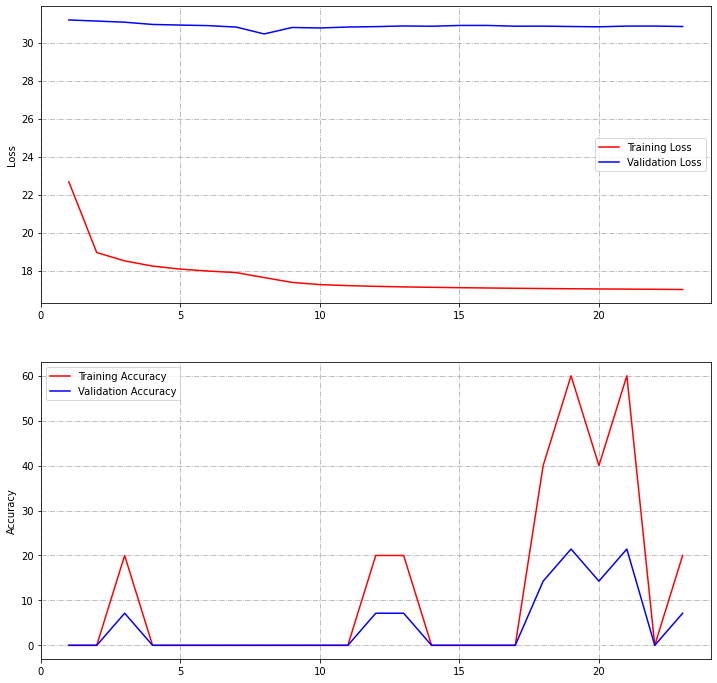

In [33]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), val_losses[:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), val_accu[:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

# Evaluation on test set 

In [34]:
x_test = test_x/255.
x_test = (test_x-train_mean)/train_std

x_test = torch.from_numpy(x_test).float()
x_test.shape
x_test.type()

'torch.FloatTensor'

In [35]:
network.eval()  
with torch.no_grad():    
    ps = network(x_test)
    prediction = torch.argmax(ps, 1)
    print('Prediction',prediction)

Prediction tensor([0, 0, 0,  ..., 4, 4, 4])


# Evaluation

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y, prediction)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y, prediction,  pos_label='positive' ,average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, prediction,  pos_label='positive' ,average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, prediction, pos_label='positive' ,average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(test_y, prediction)
print(matrix)

Accuracy: 0.671300
Precision: 0.671300
Recall: 0.671300
F1 score: 0.671300
[[ 756    1  115    1   17   46    0    0   44    0]
 [   0 1126    3    3    0    0    0    0    3    0]
 [   0    1 1027    1    0    1    0    0    2    0]
 [   0    0    3 1003    0    2    0    0    2    0]
 [   3    2    7    0  959    0    0    0   11    0]
 [   1    0    1    9    0  878    0    0    3    0]
 [ 874    7    9    1   34   24    0    0    9    0]
 [   5   41  380  414  139   17    0    0   32    0]
 [   0    0    4    3    1    2    0    0  964    0]
 [   5    8    9  216  585   41    0    0  145    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [37]:
# prepare output file
import pandas as pd
df_export = pd.DataFrame(prediction.cpu().tolist(), columns = ['Label'])
df_export['Image_label'] = df_export.index +1
df_export = df_export[['Image_label', 'Label']]
df_export.head()

,Image_label,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [38]:
# def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
#     tpr = dict()
#     roc_auc = dict()
#     fpr = dict()
# for i in range(10):
#     fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predicted[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
# # roc for each class
#     fig, ax = plt.subplots(figsize=figsize)
#     ax.plot([0, 1], [0, 1], 'k--')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.set_title('Receiver operating characteristic example')
#     for i in range(n_classes):
#         ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
#     ax.legend(loc="best")
#     ax.grid(alpha=.4)
#     sns.despine()
#     plt.show()

# plot_multiclass_roc(full_pipeline, X_test, y_test, n_classes=10, figsize=(16, 10))

# Visualization 

In [41]:
# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
# import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [42]:
%time
train_set_x1 = train_set_x.reshape (36524, 28*28)
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(train_set_x1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


ValueError: ignored

In [43]:
# train_set_y1 = train_set_y.reshape(36524, 10*0)
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=train_set_y[:, 1],cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through t-SNE', fontsize=24);

NameError: ignored

# conv layer

In [ ]:
# def plot_weights(model, layer_num, single_channel = True, collated = False):
  
#   #extracting the model features at the particular layer number
#     layers = model.network(pretrained=True)
#     layers.features[layer_num]
# #     layer = model.features[layer_num]
  
#   #checking whether the layer is convolution layer or not 
#     if isinstance(layer, nn.Conv2d):
#     #getting the weight tensor data
#         weight_tensor = model.features[nn.conv2].weight.data
    
#         if single_channel:
#             if collated:
#                 plot_filters_single_channel_big(weight_tensor)
#             else:
#                 plot_filters_single_channel(weight_tensor)
        
#         else:
#             if weight_tensor.shape[1] == 3:
#                  plot_filters_multi_channel(weight_tensor)
#             else:
#                  print("Can only plot weights with three channels with single channel = False")
        
#     else:
#              print("Can only visualize layers which are convolutional")
        
# #visualize weights for alexnet - first conv layer
# plot_weights(network, 0, single_channel = True)